# Chapter 7 n-step Bootstrapping

## 7.1 n-step TD Prediction
### Example 7.1: n-step TD Methods on the Random Walk

In [1]:
# rough interfaces

class Agent(object) :
    def __init__(self, env, policy) :
        self.env = env
        self.policy = policy
        self.time = 0
    
    def step(self) :
        current_state = self.env.state()
        action = self.policy.get_action(current_state)
        reward = self.env.action(action)
        new_state = self.env.state()
        self.state_changed(self.time, action, current_state, new_state, reward)
        self.time = self.time + 1

    def state_changed(self, time, action, old_state, new_state, reward) :
        pass
    
class Environment(object) :
    def state(self) :
        pass
    
    def is_terminal_state(self) :
        return False
    
    def action(self, act) : # transit states and return reward
        pass

    # def check_dynamics(self, state, act) : # give state, action and get next state and reward
    #    pass

class Policy(object) :
    def get_action(self, state) :
        pass

In [2]:
# Random Walk environment
# two possible actions for player : left, right
# six states : terminal (0), A (1), B (2), C (3), D (4), E (5), terminal (6)
# dynamics has following probabilities (assumed independent trials) :
#   there are 12 cards and 3 10-value cards.
#   so the probability of 10 value card is 3/12 and that of non-10 value card including ace is 1/12
#   we can simulate this by random generation of range of 1 to 12

from enum import IntEnum
import numpy as np

class RightLeft(IntEnum) :
    RIGHT = 0
    LEFT = 1
    NUM_MOVES = 2
    
    def get_deltas(direction) :
        deltas_dic = { RightLeft.RIGHT : 1, RightLeft.LEFT : -1 }
        return deltas_dic.get(direction)
    
    def get_arrow(direction) :
        arrow_dic = { RightLeft.RIGHT : '→', RightLeft.LEFT : '←' }
        return arrow_dic.get(direction)

class RandomWalk(Environment) :
    MAX_VALUE = 20
    MIN_VALUE = 0
    
    def __init__(self, max_position=MAX_VALUE, initial_position=None) :
        super(RandomWalk, self).__init__()
        self.initial_position = initial_position
        self.max_position = max_position # exclusive
        self.start()

    def start(self) :
        if self.initial_position is None :
            self.position = np.random.randint(RandomWalk.MIN_VALUE + 1, self.max_position)
        else :
            self.position = self.initial_position
        
    def is_terminal_state(self) :
        return self.check_terminal_state(self.position)

    def state(self) :
        return self.position
    
    # if move is True then move_to_left action otherwise move_to_right action is chosen
    def action(self, move) : # transit states and return reward
        if self.is_terminal_state() :
            print('already reached the terminal state') # should not happen
            return 0

        self.position, reward = self.check_dynamics(self.position, move)
        return reward

    def check_terminal_state(self, state) :
        return state == RandomWalk.MIN_VALUE or state == self.max_position

    def check_dynamics(self, state, action) : # give state, action and get next state and reward
        if self.check_terminal_state(state) :
            return state, 0

        reward = 0
        next_position = self.position + RightLeft.get_deltas(action)
        if next_position == self.max_position :
            reward = 1
        elif next_position == RandomWalk.MIN_VALUE :
            reward = -1
        return next_position, reward    

In [3]:
class RandomWalkPolicy(Policy) :
    def __init__(self) :
        super(RandomWalkPolicy, self).__init__()

    def state_key(self, state) :
        return state
        
    def get_action(self, state) : # just random
        return RightLeft.LEFT if np.random.randint(0, 2) == 1 else RightLeft.RIGHT

In [15]:
class RandomWalkNStepTDAgent(Agent) :
    NUM_EPISODES = 5000
    
    def __init__(self, env, policy, td_step, step_size = 0.1, max_value = 1.0, initial_value = 1.0,
                 true_values = None, gamma = 1.0, num_episode = NUM_EPISODES) :
        super(RandomWalkNStepTDAgent, self).__init__(env, policy)
        
        self.td_step = td_step
        self.step_size = step_size
        self.max_value = max_value
        self.num_episode = num_episode
        self.gamma = gamma
        self.initial_value = initial_value
        self.true_values = np.array(true_values)
        
        self._initialize()

    def _initialize(self) :
        self.value_dic = {}
        self.rms = np.zeros(self.num_episode)
        
    def get_value(self, state) :
        if self.env.check_terminal_state(state) :
            return 0.0
        
        state_key = self.policy.state_key(state)
        if self.value_dic.get(state_key) is not None :
            return self.value_dic[state_key] # use bootstrapped values
        
        if self.initial_value == None :
            v = np.random.random_sample() * self.max_value
            self.value_dic[state_key] = v
        else :
            self.value_dic[state_key] = self.initial_value
            v = self.initial_value
        return v

    def set_value(self, state, value) :
        state_key = self.policy.state_key(state)
        self.value_dic[state_key] = value

    def eval_policy(self) :
        for episode in range(self.num_episode) :
            self.env.start()
            while self.env.is_terminal_state() : # case natural. we can't learn policy from natural so ignore this case
                self.env.start()

            states, actions, rewards = [], [], [] # store n steps                
            state = self.env.state()
            steps = 0
            terminal_step = -1
            
            while True :
                if self.env.is_terminal_state() :
                    if terminal_step < 0 :
                        terminal_step = steps
                        states.append(state) # add terminal state
                        rewards.append(0) # add terminal reward for easy calculation
                    elif steps == terminal_step + self.td_step :
                        break
                else :
                    action = self.policy.get_action(state)
                    reward = self.env.action(action)
                    new_state = self.env.state()
                
                    states.append(state) # states[steps] == state <- S(t)
                    actions.append(action) # actions[steps] == action <- A(t+1)
                    rewards.append(reward) # rewards[steps] == reward <- R(t+1)
                
                if steps >= self.td_step - 1 : # from steps - td_step + 1 to steps
                    from_step = steps - self.td_step + 1
                    to_step = terminal_step if terminal_step >= 0 else steps # inclusive
                    g = sum([ (self.gamma ** (t - from_step + 1)) * rewards[t] for t in range(from_step, to_step + 1)])
                    if terminal_step < 0 :
                        g = g + self.gamma ** (self.td_step) * self.get_value(new_state)
                    td_start_state = states[from_step]
                    td_start_state_value = self.get_value(td_start_state)
                    self.set_value(td_start_state, td_start_state_value + self.step_size * (g - td_start_state_value))

                state = new_state
                steps = steps + 1
                
            self.end_of_episode(episode, steps)

    def run(self) :
        self.eval_policy()
        
    def end_of_episode(self, episode, steps) :
        v = np.array([ self.get_value(i) for i in range(RandomWalk.MIN_VALUE + 1, self.env.max_position) ])
        self.rms[episode] = np.sqrt(np.mean(np.square(self.true_values - v)))


In [16]:
num_runs = 100
num_episodes = 10

td_steps = [ 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 ]

rms_result = np.empty([21, len(td_steps), num_runs], dtype=np.float32)

env_rw = RandomWalk(initial_position=10) # 3 is C position
policy_rw = RandomWalkPolicy()

v_true = np.array([ 2.0 * i / 19.0 - 1.0 for i in range(1, 20) ])

for run in range(num_runs) :
    for i in range(21) :
        alpha = i / 20.0
        for j in range(len(td_steps)) :
            t = td_steps[j]
            agent_ntd_rms = RandomWalkNStepTDAgent(env_rw, policy_rw, td_step = t, true_values = v_true,
                                                   initial_value = 0.0, step_size = alpha, num_episode=num_episodes)
            agent_ntd_rms.run()
            rms_result[i, j, run] = np.mean(agent_ntd_rms.rms)

rms_avg = np.mean(rms_result, axis=2)

In [17]:
import matplotlib.pyplot as plt

# draw random walk policy rms per step size

def draw_random_walk_rms_per_alpha(rms_avg) :
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    x_axis = np.array(range(21))
    ax.set_xticks([x for x in range(21)])
    ax.set_xticklabels([ i / 20.0 for i in range(21) ])

    colors = [ 'red', 'green', 'blue', 'black', 'pink', 'cyan', 'purple', 'hotpink', 'orange', 'brown' ]
    for j in range(rms_avg.shape[1]) :
        ax.plot(x_axis, rms_avg[:, j], color=colors[j], lw=0.5, label='n='+str(td_steps[j]))
        text_pos = 20 - j * 2
        ax.text(text_pos, rms_avg[text_pos, j], 'n='+str(td_steps[j]), color=colors[j])

    ax.set_xlabel('Alpha')
    ax.set_ylabel('Average RMS error\nover 19 states\nand first 10 episodes')

    plt.show()

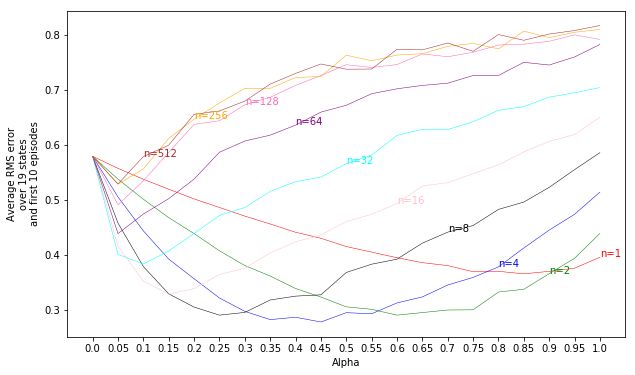

In [18]:
draw_random_walk_rms_per_alpha(rms_avg)